# Iterated map filtered 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

import time
import random
import networkx as nx
import os

from scipy.stats import norm
from scipy import signal

import Functions_Gillespie_Trajectory_Resampled as Gillespie
import sys
path='../Markov_Models/Bibliotheken/'
res2 = os.listdir(path)
print(res2)
sys.path.append(path)
import Steady_State_Calculation_Spanning_Trees as auto

['Steady_State_Calculation_Spanning_Trees.py', 'Kinesin_Parameters.py', 'Analytic_Quantities.py', 'histogram.eps', 'PDF_Flux_entropy.py', '__pycache__']


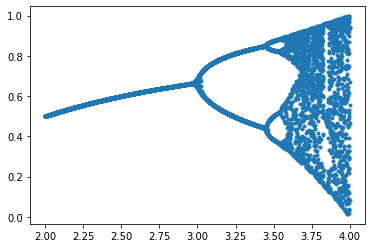

In [2]:
N = 10000
aa = np.linspace(2, 4, N)
xx = np.zeros(N)
for jj in range(N):
    a = aa[jj]
    x0 = random.random()
    for ii in range(1, 100):
        x0 = a *x0 *(1 -x0)
    xx[jj] = x0
plt.plot(aa,xx,'.')
plt.show()

In [3]:
def piecewise(x1, a1,a2,d1,d2):
    if 0<x1 and x1<d1:
        x2 = a1*x1;
    elif d1<=x1 and x1<=d2:
        x2 = (d2-x1)/(d2-d1);
    elif d2<x1 and x1<1:
        x2 = a2*(x1-1)+1;
    else:
        disp('ERROR, x_n should fulfill 0 < x_n < 1')
        x2 = -1;
    return x2

resolvable frequencies:  1000.0  = 1/5*cut-off freq
downsampling:  2


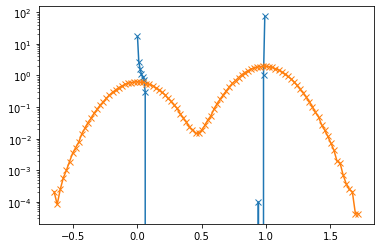

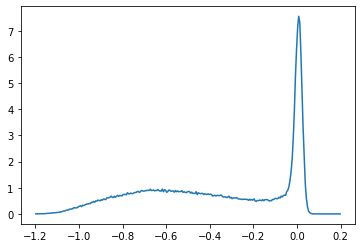

In [4]:
shift = -1
order = 4 # order of Bessel filter
cutoff_fs = 5e3 # Hz
ReSamplingFreq = 200e3; # like in exmperimental set-up
ReSamplingStep = 1/ReSamplingFreq;

sampling_fs = 2*ReSamplingFreq
sampling_step = 1/sampling_fs
print('resolvable frequencies: ', 0.2*cutoff_fs , ' = 1/5*cut-off freq')
downsampling = int(ReSamplingStep/ sampling_step)
print('downsampling: ', downsampling)

mV = -200; a1 = 1.3; a2 = 1.01; d1 = 0.05; d2 = 0.99; rescaling = 1.15; sigma_closed = 0.155; sigma_convolution = 0.02; #200mV 
#mV = -100; a1 = 1.9; a2 = 1.007; d1 = 0.2; d2 = 0.99; rescaling = 1.2; sigma_closed = 0.093; sigma_convolution = 0.012  #100mV
#mV = -40; a1 = 1.7; a2 = 1.007; d1 = 0.25; d2 = 0.99; rescaling = 1.1; sigma_closed = 0.255; sigma_convolution = 0.033

start = d1*2
No = 1000 * 2000
timeseries = -np.ones(No)
for n in range(No):
    x2 = piecewise(start, a1,a2,d1,d2);
    timeseries[n] = x2;
    start = x2;

# 3. Add noise with standard deviation according to noise level of closed state
noise1 = np.random.normal(0, sigma_closed,No)
signal_noise1 = timeseries + noise1

subset = 1000
#fig, ax = plt.subplots()
#ax.plot(timeseries[0:subset])
#ax.plot(signal_noise1[0:subset])
# Generate amplitude histograms
[hist, bin_edges] = np.histogram(timeseries[0::downsampling], density=True, bins=100) 
[hist_n, bin_edges_n] = np.histogram(signal_noise1[0::downsampling], density=True, bins=100) 
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(bin_edges[:-1], hist, '-x')
ax.plot(bin_edges_n[:-1], hist_n, '-x')

# Read experimental data
fig, ax = plt.subplots()
folder2 = '../Toy_Models/Iterated_Maps/Modelling_Breakdown/rescaled/stdScale/fixedEdges/'
fname_N = folder2 + str(mV) + 'mV_N.txt'
fname_edges = folder2 + str(mV) + 'mV_edges.txt'
exp_N = np.loadtxt(fname_N);
exp_edges = np.loadtxt(fname_edges)

plt.plot(exp_edges, exp_N)

# Filtering

sampling freq =  400000.0
sampling step =  2.5e-06


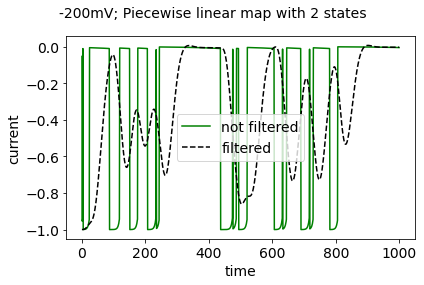

In [5]:
print('sampling freq = ', sampling_fs)
print('sampling step = ', sampling_step)
folder = 'PLM/'

sos = signal.bessel(order, Wn=cutoff_fs, btype='low', analog=False, output='sos', norm='phase', fs=sampling_fs)
y_sos = signal.sosfilt(sos, timeseries)
y_sos_noise1 = signal.sosfilt(sos, signal_noise1)
f_size =  14
fig, ax = plt.subplots()
fig.suptitle(str(mV)+'mV; ' +'Piecewise linear map with 2 states', fontsize=f_size)
ax.plot(timeseries[0:subset]+shift, color='green', label='not filtered')
ax.plot(y_sos[0:subset]+shift, '--', color='black', label='filtered')
ax.set_xlabel('time', fontsize=f_size)
ax.set_ylabel('current', fontsize=f_size)
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 14})
#ax.set_ylim([-1.1, 0.3])
fig.tight_layout()
fig.savefig(folder+str(mV)+'mV_PLM_timeseries_filtered.pdf')
plt.show()

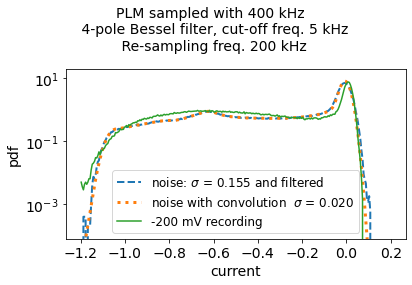

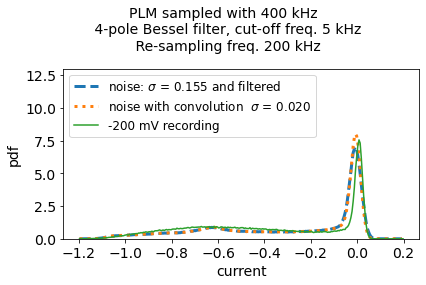

In [9]:
binning = exp_edges
[hist_f, bin_edges_f]=np.histogram(rescaling*(y_sos[0::downsampling]+shift), density=True, bins=binning) # filtered
[hist_n_f, bin_edges_n_f]=np.histogram(rescaling*(y_sos_noise1[0::downsampling]+shift), density=True, bins=binning) # filtered

# Add noise with convolution
rv1 = norm(loc = 0., scale = sigma_convolution)
dx1 = bin_edges_f[2]-bin_edges_f[1]
x = np.arange(-0.3, 0.3, dx1)
noise = rv1.pdf(x) 
filtered = signal.convolve(hist_f, noise, mode='same') / sum(noise)

fig, ax = plt.subplots()
fig.suptitle('PLM sampled with %d kHz \n 4-pole Bessel filter, cut-off freq. 5 kHz\n Re-sampling freq. %d kHz' %(int(sampling_fs/1e3) , int(ReSamplingFreq/1e3)), fontsize=f_size)

#ax.plot(bin_edges_n[:-1], hist_n, '-',  label='not filtered, with noise')
#ax.plot(bin_edges_f[:-1], hist_f, '-',  label='filtered, no noise')
ax.plot(bin_edges_n_f[:-1], hist_n_f, '--',  label='noise: $\sigma$ = %.3f and filtered' %sigma_closed, linewidth=2)
ax.plot(bin_edges_f[:-1], filtered, ':',  label='noise with convolution  $\sigma$ = %.3f' %sigma_convolution, linewidth = 3)

ax.plot(exp_edges, exp_N, label = '%d mV recording' %mV)
ax.set_xlabel('current', fontsize=f_size)
ax.set_ylabel('pdf', fontsize=f_size)
#ax.set_ylim([1e-5, 3e-1])
ax.tick_params(axis='both', labelsize=f_size)
ax.set_yscale('log')
ax.set_ylim([8e-5, 2e1])
ax.legend(prop={'size': 12})
plt.tight_layout()
plt.savefig(folder+str(mV)+'PLM_'+str(mV)+'_mV_log.pdf', bbox_inches='tight')

# no log scale
fig, ax = plt.subplots()
fig.suptitle('PLM sampled with %d kHz \n 4-pole Bessel filter, cut-off freq. 5 kHz\n Re-sampling freq. %d kHz' %(int(sampling_fs/1e3) , int(ReSamplingFreq/1e3)), fontsize=f_size)

#ax.plot(bin_edges_n[:-1], hist_n, '-',  label='not filtered, with noise')
#ax.plot(bin_edges_f[:-1], hist_f, '-',  label='filtered and no noise')
ax.plot(bin_edges_n_f[:-1], hist_n_f, '--',  label='noise: $\sigma$ = %.3f and filtered'%sigma_closed, linewidth=3)
ax.plot(bin_edges_f[:-1], filtered, ':',  label='noise with convolution  $\sigma$ = %.3f' %sigma_convolution, linewidth = 3)
ax.plot(exp_edges, exp_N, label = '%d mV recording' %mV)
ax.set_xlabel('current', fontsize=f_size)
ax.set_ylabel('pdf', fontsize=f_size)
ax.set_ylim([0, 13])
ax.tick_params(axis='both', labelsize=f_size)
ax.legend(prop={'size': 12.}, loc='upper left')
plt.tight_layout()
plt.savefig(folder+str(mV)+'PLM_'+str(mV)+'_mV.pdf', bbox_inches='tight')

# write out trajectories
np.savetxt('PLM/PLM_traj_'+str(mV)+'_mV_noNoise.txt', y_sos[0::downsampling])
np.savetxt('PLM/PLM_traj_'+str(mV)+'_mV_Noise.txt', y_sos_noise1[0::downsampling])

# Estimate noise level before filtering

In [7]:
print('length of sampled states = ', No)
std_noise1 = sigma_closed
noise1 = np.random.normal(0, sigma_closed,No)
print('std. dev. of noise ', np.std(noise1))

# filter
noise_sos = signal.sosfilt(sos, noise1)
print('std. dev. of noise after filtering', np.std(noise_sos))

#downsampling
noise_sos = signal.sosfilt(sos, noise1)
print('std. dev. of noise after filtering and downsampling', np.std(noise_sos[0::downsampling]))
print('downsampling', downsampling)

length of sampled states =  2000000
std. dev. of noise  0.15511309226026798
std. dev. of noise after filtering 0.02046955342659957
std. dev. of noise after filtering and downsampling 0.02046955000476877
downsampling 2


0.004999999999999893 0.0050000000000001155
length of noise  121
length of hist_f  279


<ipython-input-8-f53bdb0f7102>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


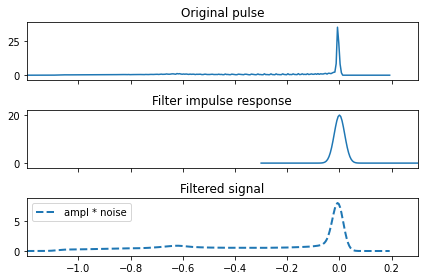

In [8]:
# make vectors equi-distant
dx1 = bin_edges_f[2]-bin_edges_f[1]
dx2 = bin_edges_f[10]-bin_edges_f[9]
print(dx1, dx2)

rv1 = norm(loc = 0, scale = sigma_convolution)#
x = np.arange(-.3, .3, dx1)#np.linspace(-.3, 0.3, len(hist_f))
noise = rv1.pdf(x) 
print('length of noise ', len(noise))
filtered = signal.convolve(hist_f, noise, mode='same') / sum(noise)
filtered2 = signal.convolve(noise,hist_f, mode='same') / sum(hist_f)

print('length of hist_f ',len(hist_f))

fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(bin_edges_f[:-1], hist_f)
#ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)

ax_win.plot(x, noise)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)

ax_filt.plot(bin_edges_f[:-1], filtered, '--', label='ampl * noise', linewidth=2)
#ax_filt.plot(bin_edges_f[:-1], filtered2, label='noise * ampl')
#ax_filt.plot(exp_edges, exp_N, label = '%d mV recording' %mV)
ax_filt.legend(loc='upper left')
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()